In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats, special
import warnings
warnings.filterwarnings(action='ignore')
sns.set_style('darkgrid')

In [3]:
train, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
corr = train.corr()
pd.DataFrame(abs(corr.SalePrice).sort_values(ascending=False)[:10])

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


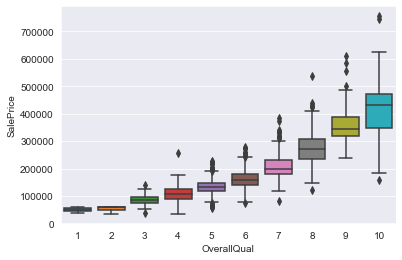

In [16]:
sns.boxplot(data=train[['OverallQual', 'SalePrice']], x='OverallQual', y='SalePrice')
plt.show()

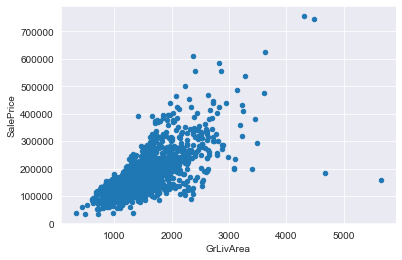

In [19]:
train[['GrLivArea', 'SalePrice']].plot.scatter(x='GrLivArea', y='SalePrice')
plt.show()

In [22]:
train.drop(train.GrLivArea.sort_values(ascending=False)[:2].index, axis=0, inplace=True)

In [24]:
X_train, y_train = train.drop(['SalePrice'], axis=1), train.SalePrice

In [26]:
X_total = pd.concat((X_train, test), axis=0)

In [29]:
y_train = np.log1p(y_train)

In [33]:
import optuna
from functools import partial
from xgboost import XGBRegressor

In [35]:
def objective(trial, X, y):
    param = {
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'learning_rate': trial.suggetst_uniform('learning_rate', 0.005, 0.01),
        'subsample': trial.suggest_categorical('subsample', list(range(0.4, 1,1, 0.1))),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', list(range(0.4, 1,1, 0.1))),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
        'n_job': -1
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBRegressor(**param)
    train_scores, valid_scores = [], []
    for train_idx, valid_idx in kf.split(X_train):
        X_tmp_train, X_tmp_valid = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
        y_tmp_train, y_tmp_valid = y_train[train_idx], y_train[valid_idx]
        model = model.fit(X_tmp_train, y_tmp_train,
                         eval_set=[(X_tmp_valid, y_tmp_valid)], eval_metric=['rmse'],
                         early_stopping_rounds=30,
                         Callbacks=optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse'))
        
        train_scores.append(np.sqrt(mean_squared_error(y_tmp_train, model.predict(X_tmp_train))))
        valid_scores.append(np.sqrt(mean_squared_error(y_tmp_valid, model.predict(X_tmp_valid))))
    
    return train.scores.mean()

In [ ]:
optimizer = partial(objective, X=X_train, y=y_train)
study = optuna.create_study(direction='minimize')
study.optimize(optimizer, n_trial=100)

In [47]:
optuna.integration.LightGBMPruningCallback

optuna.integration.lightgbm.LightGBMPruningCallback